# OpenAI gym's Taxi-v3 task

For this coding exercise, we will use OpenAI gym's [Taxi-v3](https://gym.openai.com/envs/Taxi-v3/) environment to design an algorithm to teach a taxi agent to navigate a small gridworld. There are 4 locations (labeled by different letters) and our job is to pick up the passenger at one location and drop him off in another. We will receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

The Taxi Problem   
from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition" by Tom Dietterich

Description:  
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

Observations:  
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode.
Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination.
This gives a total of 404 reachable discrete states.

Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

Actions:  
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

Rewards:  
There is a default per-step reward of -1, except for delivering the passenger, which is +20, or executing "pickup" and "drop-off" actions illegally, which is -10.

Rendering:  
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, Y and B): locations for passengers and destinations

State space is represented by:  
(taxi_row, taxi_col, passenger_location, destination)

### Specify the environment, and explore the state & action spaces

Create an instance of the [Taxi-V3](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py) environment that has a discreate state and action spaces.

In [1]:
import gym

# create the environment and set random seed
env = gym.make('Taxi-v3')
env.seed(505)
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(500)
Action space: Discrete(6)


### Specify the interaction

It might be helpful to get some experience with the output that is returned as the agent interacts with the environment.

In [2]:
from collections import deque
import math, sys
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def interact(env, agent, num_episodes=20000, window=100):
    """
    Monitor agent's performance.
    
    Params
    ==========
    - env: instance of OpenAI Gym's Taxi-v3 environment.
    - agent: instance of class Agent (see Agent class for details).
    - num_episodes: number of episodes of agent-environment interaction.
    - window: number of episodes to consider when calculating average rewards.
    
    Returns
    =======
    - samp_rewards: list containing final sampled reward/episode.
    - avg_rewards: deque containing average rewards.
    - best_avg: largest value in the avg_rewards deque.
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = []
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # begin the episode, observe S
        state = env.reset()
        # initialize sampled reward
        samp_reward = 0
        # roll out steps until done
        done = False
        while not done:
            # agent selects an action
            action = agent.select_action(state)
            # agent performs the selected action, observe R, S'
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
        # save final sampled reward
        samp_rewards.append(samp_reward)
        # monitor performance over number of consecutive episodes
        if (len(samp_rewards)>=window):
            # get average reward from last number of episodes.
            avg_reward = np.mean(samp_rewards[-window:])
            # append to deque 
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        clear_output(wait=True)
        print("\rEpisode {}/{} || Best average reward {}\n".format(
            i_episode, num_episodes, best_avg_reward), end="")
        # watch agent interacts with environment.
#         print(env.render(mode='ansi'))
#         sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward>=9.7:
            print(f"\nEnvironment solved in {i_episode} episodes", end="")
    # plot performance
    _, ax = plt.subplots(2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.3)
    # plot final sampled reward obtained per episode as well as a rolling mean
    rolling_mean = pd.Series(samp_rewards).rolling(window).mean()
    ax[0].plot(samp_rewards, label="Sampled reward")
    ax[0].plot(rolling_mean, label="Rolling mean")
    ax[0].legend(loc="upper left")
    ax[0].set_title(f"Sampled reward per episode & rolling mean")
    ax[0].set_ylabel("Reward")
    ax[0].set_xlabel("Episode Number")
    # plot average reward over number consecutive episodes
    ax[1].plot(np.linspace(0, num_episodes, len(avg_rewards), 
        endpoint=False), np.asarray(avg_rewards))
    ax[1].set_title(f"Average reward (over {window} consecutive episodes)")
    ax[1].set_ylabel("Average reward")
    ax[1].set_xlabel("Episode Number")
    plt.show()
    
    return samp_rewards, avg_rewards, best_avg_reward

### TD Control: Q-Learning

Provided below is an Q-Learning agent. The algorithm updates the dictionary of `Q` where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [3]:
import numpy as np
from collections import defaultdict

class Agent:
    """
    Q-learning agent that act on the OpenAI Gym's Taxi-v3 environment.
    """
    
    def __init__(self, env, alpha=0.02, gamma=0.99, epsilon=1.0, 
        epsilon_decay_rate=0.9995, min_epsilon=.01):
        """
        Initialize agent.

        Params
        ======
        - env: instance of OpenAI Gym's Taxi-v3 environment.
        """
        # enviroment info
        self.nA = env.nA
        # learning parameters:
        # learning rate
        self.alpha = alpha
        # discount factor
        self.gamma = gamma
        # initial exploration rate
        self.epsilon = self.initial_epsilon = epsilon
        # how quickly should epsilon decrease
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        # initialize action-value function (empty dictionary of arrays)
        self.Q = defaultdict(lambda: np.zeros(self.nA))
     
    def select_action(self, state):
        """
        Given the state, select an action.

        Params
        ======
        - state: the current state of the environment.

        Returns
        =======
        - action: an integer, compatible with the task's action space.
        """
        # reset epsilon for a new episode, 
        # decrease exploration rate gradually
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        # get epsilon-greedy policy
        policy_s = np.ones(self.nA) * self.epsilon / self.nA
        policy_s[np.argmax(self.Q[state])] = \
            1 - self.epsilon + (self.epsilon / self.nA)
        return np.random.choice(np.arange(self.nA), p=policy_s)

    def step(self, state, action, reward, next_state, done):
        """
        Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment.
        - action: the agent's previous choice of action.
        - reward: last reward received.
        - next_state: the current state of the environment.
        - done: whether the episode is complete (True or False).
        """
        if not done:
            self.Q[state][action] += self.alpha * (reward + 
                self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
        if done:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])

Execute the code cell below to play **Taxi-v3** with a TD policy in 20000 episodes.

Episode 20000/20000 || Best average reward 8.66


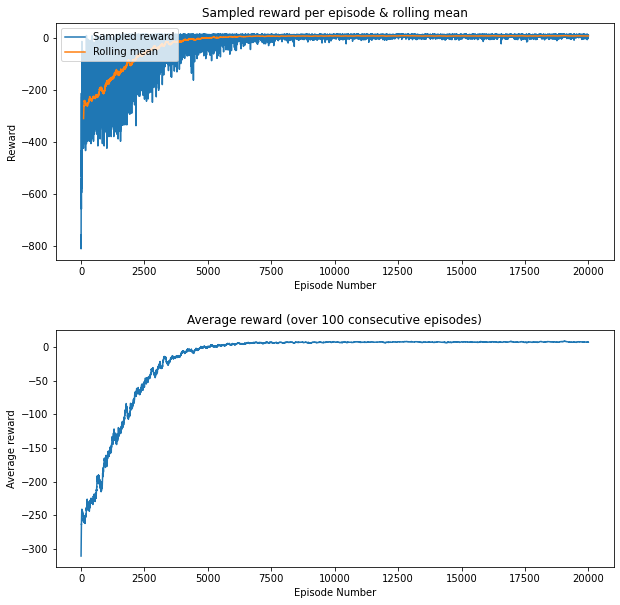

In [4]:
agent = Agent(env)
samp_rewards, avg_rewards, best_avg_reward = interact(
    env, agent, num_episodes=20000)

In [ ]:
from collections import deque
import sys
import math
import numpy as np

def interact(env, agent, num_episodes=20000, window=100):
    """ Monitor agent's performance.
    
    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state = env.reset()
        # initialize the sampled reward
        samp_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 100):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward

In [ ]:
import numpy as np
from collections import defaultdict

class Agent:

    def __init__(self, nA=6):
        """
        Initialize agent.

        Params
        ======
        nA: integer
            Number of actions available to the agent
        """
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))

    def select_action(self, state):
        """
        Given the state, select an action.

        Params
        ======
        state: integer
            The current state of the environment

        Returns
        =======
        action: integer 
            The task's action space
        """
        return np.random.choice(self.nA)

    def step(self, state, action, reward, next_state, done):
        """
        Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        state: integer
            The previous state of the environment.
        action: integer
            The agent's previous choice of action.
        reward: integer 
            Last reward received.
        next_state: integer
            The current state of the environment.
        done: logic
            Whether the episode is complete (True or False)
        """
        self.Q[state][action] += 1

In [ ]:
from agent import Agent
from monitor import interact
import gym
import numpy as np

env = gym.make('Taxi-v2')
agent = Agent()
avg_rewards, best_avg_reward = interact(env, agent)